In [8]:
import pandas as pd
import re # regex module from python 
from pathlib import Path #python module to navigate into the Filesystem
import fitz # to parse PDF (PyMuPDF package)
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

In [9]:
#Load the database

articledb = pd.read_csv('C:/Users/pjcun/Dropbox/M2 AI4PH/NLP/NLP_LitReview/results/Familly NICU.csv')

I use the package PyMuPDF to extract the raw text from the .pdf article. (this article is a comparison of different solution existing : https://arxiv.org/html/2410.09871v1).

After a first raw text extraction, we'll try to identify the body of the article using RegEx. The isolation of the body of text is essential for the understanding of the article topics.


In [10]:
# creation of an extraction function with fitz

def extract_pdf_text(path):
    doc = fitz.open(path)
    texts = []
    for page in doc: # basic extraction page after page
        txt = page.get_text("text") 
        texts.append(txt)
    doc.close()
    full_text = "\n".join(texts)
    return full_text


In [11]:
#Listing of pdf file from the path results\Full article
dossier = Path("Full article/")
pdf_name = [f.name for f in dossier.iterdir()]

In [12]:
pdf_strip = []

for art in range(len(pdf_name)):
    pdf_strip.append(extract_pdf_text(f'Full article/{pdf_name[art]}'))


In [13]:
# create a function which extract the body of the text
# we use Regex to try to limit the body of the text

def body_extraction(text):
    
    text = text.replace("\u00a0", " ")  # unbreakable space
    text = re.sub(r"[ \t]+", " ", text) # horizontal space normalisation
    text = re.sub(r"\n{3,}", "\n\n", text) # vertical space normalisation
    lines = [l.strip() for l in text.splitlines()]
    lines = [l for l in lines if l]  # remove empty line
  
  
    intro_pat = re.compile(r"^(introduction|background)$", re.IGNORECASE)
    stop_pats = [
        re.compile(r"^(references|bibliography|literature cited)$", re.IGNORECASE),
        re.compile(r"^(acknowledg(e)?ments?)$", re.IGNORECASE),
        re.compile(r"^(supplementary( material)?|appendix|annexe[s]?)$", re.IGNORECASE),
    ]

    in_body = False
    kept = []

    for line in lines: # find beginning
        if not in_body and intro_pat.match(line):
            in_body = True
            kept.append(line)
            continue

        if in_body: # find the end
            if any(p.match(line) for p in stop_pats):
                break
            kept.append(line)

    if not kept: # kept the text from the beginning if the is no introcution find
        kept = lines

    body_text = "\n".join(kept)
    return body_text


In [14]:
body = []

for be in range(len(pdf_strip)):
    body.append(body_extraction(pdf_strip[be]))

In [15]:
body

["Introduction\nBackground\nStroke is a highly prevalent public health concern, and\nthe leading cause of death and disability among adults in\ndeveloped countries [1, 2]. In the USA alone, stroke has\nan annual incidence of approximately 795,000, and is as-\nsociated with an estimated 34 billion dollar cost from\nhealth care services, medications, and missed days of\nwork [1]. A stroke is often a devastating life-altering\nevent for both patients and their family/friend caregivers\n[3–5]. Stroke occurs without warning and may result\nnot only in death or profound disability but also sub-\nstantial emotional trauma for both patients and care-\ngivers [5, 6]. Although advances in endovascular and\nneurocritical care approaches to stroke treatment and\nrecovery have substantially increase the number of survi-\nvors, there remains a need to develop treatments to ad-\ndress the emotional sequelae associated with the stroke\nand subsequent hospitalization for both patients and\ntheir inform

After a quick look on the extracted text, we can do improvement with simple RegEx:

- Removing the pattern like *particu-\nlarly, irrita-\nbility, ... * which is quite frequent and represent are word separated on two line.
- Removing the pattern *\n* whic is not really informative.
- Removing the reference which are beetween square brakets
- Removing URL & DOI



In [16]:
def regex_corrector(text):
    text =  re.sub(r"-\n(\w+)", r"\1", text) # remove -\n
    text = re.sub(r"\n", " ", text) # remove \n 
    text =  re.sub(r"\[\s*\d+(?:\s*[-,]\s*\d+)*\s*\]", "", text) # remove [1], [3,4,5], [12–14] ...
    text = re.sub(r"https?://\S+|www\.\S+", "", text) # URL
    text = re.sub(r"\bdoi:\s*\S+", "", text, flags=re.IGNORECASE) # doi: DOI:
    text = re.sub(r"\b10\.\d{4,9}/\S+\b", "", text) # 10.xxx\

    return text


In [17]:
for be in range(len(body)):
    body[be] = regex_corrector(body[be])

In [18]:
pd.DataFrame(body).to_csv("extracted.csv")

In [19]:
# remove the stop words with scikit kearn

# Stop word anglais commun + adding common medical stop word.

SUPPLEMENTARY_STOP_WORDS = {
    'care', 'ICU',
    'study', 'studies', 'hospital', 'method', 'result', "admission",
    "admitted", "Introduction", "Background", "Methods", "Results", "Discussion", "Conclusion",
} 

ENGLISH_STOP_WORDS = set(ENGLISH_STOP_WORDS).union(SUPPLEMENTARY_STOP_WORDS)

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def stp_wrd(text):
    filtered = [w for w in text.lower().split() if w not in ENGLISH_STOP_WORDS]
    return ' '.join(filtered)

for be in range(len(body)):
    body[be] = stp_wrd(body[be])

i'd like to do a thematic analysis of theses article using AI models derived from transformers (BERT). The BERTopic approach seems to be interesting to do this kind of analysis. (92 arcicles in 2025 using BERTopic in PubMed)

i'll do an embeding foe each article' raw text and then use a clustering algorithm to group the articles into themes.

The PubMedBERT Embeddings model (https://huggingface.co/NeuML/pubmedbert-base-embeddings) ,seems to be a good choice for my medical corpus of articles text.


In [20]:
body = pd.Series(body)

In [21]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN


embedding_model = SentenceTransformer("NeuML/pubmedbert-base-embeddings")

embeddings = embedding_model.encode(body, show_progress_bar=True)
#Tune TD IDF
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True,bm25_weighting=True) 
#Reduce Dimension
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.7, metric='cosine')
#Tune HDBSCAN
hdbscan_model = HDBSCAN(
    min_cluster_size=4,   
    min_samples=2,  
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

topic_model = BERTopic(
    embedding_model=embedding_model,
    hdbscan_model=hdbscan_model,
    umap_model=umap_model,
    min_topic_size=5, # we had few article, so i give a low limit value
    verbose=True,
    calculate_probabilities=True,
    ctfidf_model=ctfidf_model
)

topics, probs = topic_model.fit_transform(body, embeddings)

topic_model.get_topic_info()


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-20 17:06:20,204 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-20 17:06:27,593 - BERTopic - Dimensionality - Completed ✓
2026-01-20 17:06:27,595 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-20 17:06:27,609 - BERTopic - Cluster - Completed ✓
2026-01-20 17:06:27,615 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-20 17:06:27,672 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,1,-1_session_vsma_virtual_wright,"[session, vsma, virtual, wright, sessions, mah...",[neurosurgical focus neurosurg focus 52 (6):e1...
1,0,10,0_caregivers_family_patients_anxiety,"[caregivers, family, patients, anxiety, sympto...",[introduction admission neurological intensive...
2,1,10,1_care_patient_patients_ccm,"[care, patient, patients, ccm, palliative, tea...",[introduction patients admitted neurocritical ...
3,2,5,2_pics_survivors_icu_cognitive,"[pics, survivors, icu, cognitive, studies, mon...",[introduction ﬁeld critical care rapidly expan...


In [22]:
topic_model.visualize_topics()

In [23]:
fig = topic_model.visualize_barchart()
fig.show()

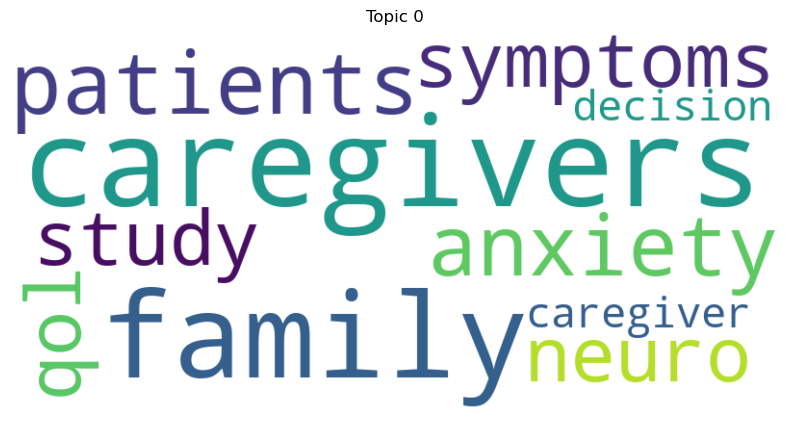

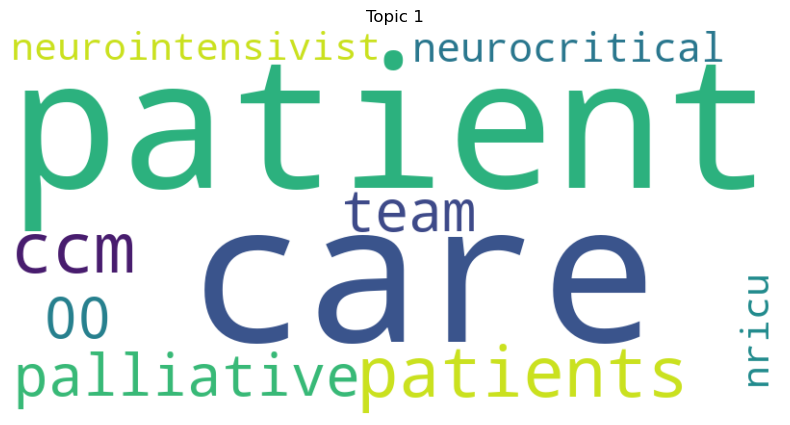

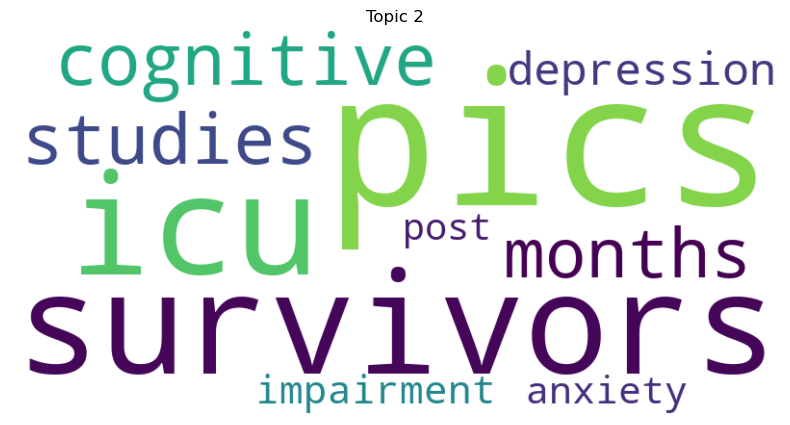

In [24]:
def plot_wordcloud_from_topic_terms(topic_model, topic_id, top_n=50):
    terms = topic_model.get_topic(topic_id)  # list of (word, score)
    if not terms:
        print(f"No terms for topic {topic_id}")
        return

    freqs = {w: s for w, s in terms[:top_n]}

    wc = WordCloud(
        width=800,
        height=400,
        background_color="white"
    ).generate_from_frequencies(freqs)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {topic_id}")
    plt.show()

plot_wordcloud_from_topic_terms(topic_model, 0)
plot_wordcloud_from_topic_terms(topic_model, 1)
plot_wordcloud_from_topic_terms(topic_model, 2)

In [ ]:
# fuction for extract 'Document' from a specidied cluster


In [ ]:
import os
import json
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import AIMessage

LLM_CONFIG = {
    "base_url": "http://localhost:1234/v1",
    "model": "local-model",
    "temperature": 0.1,
    "max_tokens": 50000
}


llm = ChatOpenAI(
    api_key="lm-studio",
    base_url=LLM_CONFIG["base_url"],
    model=LLM_CONFIG["model"],
    temperature=LLM_CONFIG["temperature"],
    max_tokens=LLM_CONFIG["max_tokens"]
)



In [27]:
# creation of a optimized prompt in markdown with a forced JSON output to optimise the response

THEMATIC_PROMPT = PromptTemplate.from_template(
    """You are an expert in scientific literature analysis.

**CORPUS TO ANALYZE:**
{corpus_text}

**INSTRUCTIONS:**
1. Carefully read the corpus above
2. Identify 3 to 5 main themes (no more than 5)
3. For each theme:
   - Provide a short title (3-6 words maximum)
   - Write a clear description (15-30 words)
   - List 3-5 relevant key concepts
4. Summarize the main message of the corpus in 1-2 sentences (20-40 words)
5. Each article is separated by \n\n--- NEW ARTICLE ---\n\n

**IMPORTANT RULES:**
- Base your analysis ONLY on the provided corpus
- Do not mention external information
- Use precise scientific vocabulary
- Remain factual and objective

**RESPONSE FORMAT:**
Respond in valid JSON only, with no text before or after. Exact structure:
{{
  "thematic_axes": [
    {{
      "article analysed:"Number of articles in the cluster"
      "theme": "theme title",
      "description": "short and precise description",
      "key_concepts": ["concept1", "concept2", "concept3"]
    }}
  ],
  "main_message": "synthesis in a short paragraph"
}}

JSON RESPONSE:"""
)

In [28]:
# prompt for methodological analysis

METHODOLOGY_PROMPT = PromptTemplate.from_template(
    """You are an expert in scientific research methodology.

**CORPUS TO ANALYZE:**
{corpus_text}

**INSTRUCTIONS:**
1. Carefully read the corpus above
2. Identify the dominant methodology (only one: meta-analysis, cohort study, randomized clinical trial, systematic review, modeling, cross-sectional study, etc.)
3. Describe common methodological characteristics in 20-40 words
4. List 3-7 statistical or algorithmic techniques identified in the corpus
5. List 2-5 tools, software, or databases mentioned (if present)
6. Each article is separated by \n\n--- NEW ARTICLE ---\n\n

**IMPORTANT RULES:**
- Extract ONLY information present in the corpus
- If information is not available, use an empty list []
- Use exact names of methods/tools as mentioned
- Avoid interpretations or assumptions
- Remain precise and factual

**RESPONSE FORMAT:**
Respond in valid JSON only, with no text before or after. Exact structure:
{{
  "dominant_methodology": "precise methodology name",
  "methodological_description": "common characteristics in 20-40 words",
  "statistical_techniques": ["technique1", "technique2", "technique3"],
  "tools_databases": ["tool1", "tool2"]
}}

JSON RESPONSE:"""
)

In [ ]:
def text_by_cluster(topic_model, documents, cluster_id):
    doc_info = topic_model.get_document_info(documents)
    cluster_docs = doc_info[doc_info['Topic'] == cluster_id]['Document'].tolist()
    return cluster_docs
    

def analyze_theme(topic_model, documents, cluster_id, llm):
    cluster_docs = text_by_cluster(topic_model, documents, cluster_id)
    corpus_text = "\n\n--- NEW ARTICLE ---\n\n".join(cluster_docs) 
    
    print(f"Thematic analysis for cluster {cluster_id}")
    thematic_chain = THEMATIC_PROMPT | llm
    thematic_result = thematic_chain.invoke({"corpus_text": corpus_text})
    
    return thematic_result


def analyze_methodo(topic_model, documents, cluster_id, llm):
    cluster_docs = text_by_cluster(topic_model, documents, cluster_id)
    corpus_text = "\n\n--- NEW ARTICLE ---\n\n".join(cluster_docs) 
    
    print(f"Methodological analysis for cluster {cluster_id}")
    methodology_chain = METHODOLOGY_PROMPT | llm
    methodology_result = methodology_chain.invoke({"corpus_text": corpus_text})

    return methodology_result


In [78]:
topic0 = analyze_theme(topic_model, body, 0, llm).content
topic1 = analyze_theme(topic_model, body, 1, llm).content
topic2 = analyze_theme(topic_model, body, 2, llm).content


Thematic analysis for cluster 0
Thematic analysis for cluster 1
Thematic analysis for cluster 2


In [79]:
methodo0 = analyze_methodo(topic_model, body, 0, llm).content
methodo1 = analyze_methodo(topic_model, body, 1, llm).content
methodo2 = analyze_methodo(topic_model, body, 2, llm).content

Methodological analysis for cluster 0
Methodological analysis for cluster 1
Methodological analysis for cluster 2


In [82]:
data0 = json.loads(topic0)
data1 = json.loads(topic1)
data2 = json.loads(topic2)


In [89]:
meth0 = json.loads(methodo0)
meth1 = json.loads(methodo1)
meth2 = json.loads(methodo2)

Topic 0 sub-topic analysis

In [76]:
data0['thematic_axes']

[{'articles_analysed': 6,
  'theme': 'Psychological Distress in Neurocritical Care',
  'description': 'High rates of depression, anxiety, and PTSD in patients and caregivers following neurological injuries, impacting quality of life.',
  'key_concepts': ['depression', 'anxiety', 'PTSD', 'quality of life']},
 {'articles_analysed': 4,
  'theme': 'Dyadic and Family-Centered Interventions',
  'description': 'Interventions targeting both patients and caregivers to build resilience, prevent chronic emotional distress, and involve families in care.',
  'key_concepts': ['dyadic intervention',
   'mindfulness',
   'coping skills',
   'family involvement']},
 {'articles_analysed': 2,
  'theme': 'Caregiver Burden and Mental Health',
  'description': 'Caregivers experience significant burden, depression, and anxiety, influenced by factors like personality traits and caregiving demands.',
  'key_concepts': ['caregiver burden',
   'depression',
   'mental health trajectories',
   'personality traits

Topic 1 sub-topic analysis

In [83]:
data1['thematic_axes']

[{'articles_analysed': 4,
  'theme': 'Palliative Care Integration',
  'description': 'Integration of palliative care in neurocritical settings to manage symptoms, facilitate goals-of-care conversations, and support families.',
  'key_concepts': ['goals-of-care conversations',
   'symptom management',
   'family psychosocial support',
   'end-of-life care']},
 {'articles_analysed': 4,
  'theme': 'Family-Centered Communication',
  'description': 'Strategies to enhance family involvement through cultural mediation, unit redesign, and improved communication frameworks.',
  'key_concepts': ['cultural mediation',
   'family-centered design',
   'communication frameworks',
   'bereavement support']},
 {'articles_analysed': 4,
  'theme': 'Neurocritical Care Team Impact',
  'description': 'Benefits of dedicated neurointensivists and specialized teams on clinical outcomes, quality metrics, and patient satisfaction.',
  'key_concepts': ['neurointensivist',
   'quality metrics',
   'length of stay

Topic 2 sub-topic analysis

In [84]:
data2['thematic_axes']

[{'article analysed': '4',
  'theme': 'Definition and Components of PICS/PICS-F',
  'description': 'PICS involves physical, cognitive, and mental impairments in ICU survivors; PICS-F refers to psychological distress in their relatives.',
  'key_concepts': ['Post-intensive care syndrome',
   'PICS-F',
   'Multidimensional impairments',
   'Anxiety',
   'Depression']},
 {'article analysed': '4',
  'theme': 'Mental Health Impact on Quality of Life',
  'description': 'Mental components like anxiety, depression, and PTSD significantly reduce quality of life for both survivors and families.',
  'key_concepts': ['Quality of life',
   'Psychological sequelae',
   'Anxiety',
   'Depression',
   'PTSD']},
 {'article analysed': '3',
  'theme': 'Risk Factors and Clinical Challenges',
  'description': 'Risk factors include delirium, sedation, and ICU length of stay; neurocritical care poses challenges due to overlapping injuries.',
  'key_concepts': ['Delirium',
   'Sedation',
   'ICU length of sta